In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.5)
from tqdm import tqdm

from qiskit import QuantumCircuit, Aer
from qiskit.algorithms import VQE
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation, PauliSumOp
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import ADAM

from src.utils import write_to_csv
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.ibmq import least_busy
from qiskit.utils import QuantumInstance


In [39]:
def prepare_state():
    theta = Parameter('theta')
    phi = Parameter('phi')
    QC = QuantumCircuit(1)
    QC.rx(2*(theta-np.pi/2),0)
    QC.ry(2*(phi-np.pi/2),0)
    return QC

def Hamiltonian(lmb):
    E1 = 0
    E2 = 4
    V11 = 3
    V22 = -3
    V12 = 0.2
    V21 = 0.2

    eps = (E1 + E2) / 2
    omega = (E1 - E2) / 2
    c = (V11 + V22) / 2
    omega_z = (V11 - V22) / 2
    omega_x = V12

    # H = eps * I + omega * Z + lmb * (c * I + omega_z * Z + omega_x * X)    
    H = PauliSumOp.from_list([('I', eps + lmb*c), ('Z', omega + lmb*omega_z), 
                              ('X', lmb*omega_x)])

    return H

In [52]:
from qiskit import IBMQ
IBMQ.load_account()
provider = QiskitRuntimeService(channel='ibm_quantum')

IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

In [53]:
print(provider.backends())

[<IBMBackend('ibmq_belem')>, <IBMBackend('ibm_lagos')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_oslo')>, <IBMBackend('ibmq_quito')>, <IBMBackend('simulator_mps')>, <IBMBackend('ibmq_manila')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('ibmq_lima')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibm_nairobi')>]


In [55]:
def get_energy_qiskit(experiment, n_points):
    if experiment == 'simulate':
        instance = Aer.get_backend('qasm_simulator')
        filename = 'data/simulate'
        expecation = AerPauliExpectation()
    elif experiment == 'real':
        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and 
                                                     not x.configuration().simulator and x.status().operational==True))
        # backend = provider.get_backend('ibm_oslo')
        shots = 1024
        instance = QuantumInstance(backend, shots=shots)
        filename = f'data/real_{backend.name}'
        expecation = None
        print(f'Running on backend: {backend.name}')
    else:
        raise ValueError('experiment must be either "simulate" or "real"')

    adam = ADAM(maxiter=10_000) #optimizer for VQE
    lmbvalues_qk = range(n_points)
    min_energy_qk = np.zeros(n_points)
    for index, lmb in enumerate(tqdm(lmbvalues_qk)):
        lmb = lmb/n_points
        H = Hamiltonian(lmb)
        # H = X
        # H = PauliSumOp.from_list([("X", -1), ("X", -1), ("X", -1), ("Z", -1)])
        init_point = np.random.uniform(low = 0, high = np.pi, size = 2)
        vqe = VQE(ansatz=prepare_state(), optimizer=adam, initial_point=init_point, 
                    quantum_instance=instance, expectation=expecation)
        result = vqe.compute_minimum_eigenvalue(H)
        min_energy_qk[index] = result.eigenvalue.real
    lmbvalues_qk = np.linspace(0, 1 - 1/n_points, n_points)
    write_to_csv(lmbvalues_qk, min_energy_qk, filename=filename, header='lmb,energy')

In [62]:
get_energy_qiskit('simulate', n_points = 10)

 30%|███       | 3/10 [00:38<01:25, 12.25s/it]

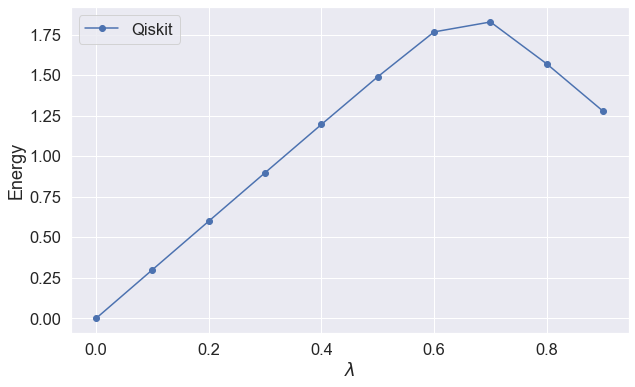

In [60]:
import pandas as pd

df = pd.read_csv('data/simulate.csv')
#rename the columns 
df.columns = ['lmb', 'energy']
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.plot(df['lmb'], df['energy'], label='Qiskit', marker = 'o')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
axs.legend()
plt.show()

In [13]:

# # Save an IBM Quantum account.
# from qiskit import *

from qiskit import IBMQ
# QiskitRuntimeService.save_account(channel='ibm_quantum', token='cf601c2a41f6b0f0fe8030c8a8c30fd4d5d9d3a4c04f3d4bb070ff7fa4a02de73998a1c22b3db1e211d536e8a02158464d27e78082220cf557267830887dcb07')

# print the least busy backend
print(backend)

<IBMBackend('ibmq_lima')>
